[*********************100%***********************]  3 of 3 completed


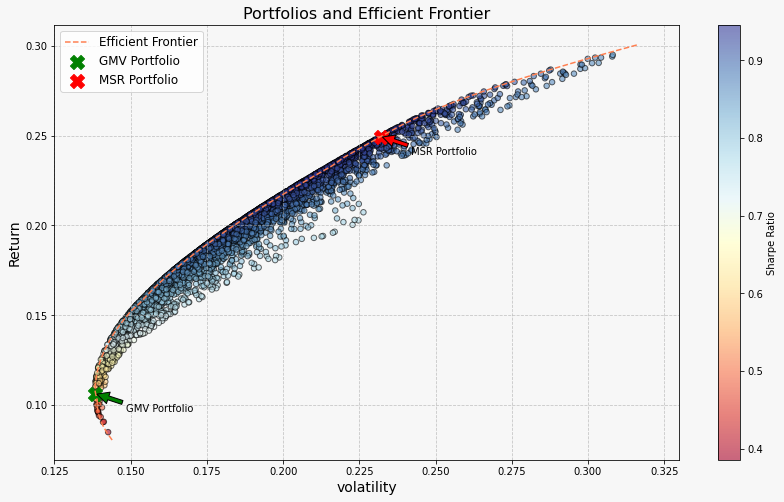

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
import sys
sys.path.append("../")
import edhec_risk_kit as erk

tickers = ['AMZN', 'KO', 'MSFT']
n_assets = len(tickers)

# Fetch data using yfinance
stocks_data = yf.download(tickers, start='2011-01-01', end='2019-01-01')

# Compute the daily returns
daily_rets = erk.compute_returns(stocks_data["Close"])

# Annualize returns (periods = 252)
ann_rets = erk.annualize_rets(daily_rets, 252)

# Compute the mean daily returns and the covariance of daily returns of the assets
mean_rets = daily_rets.mean()
std_rets = daily_rets.std()
cov_rets = daily_rets.cov()

periods_per_year = 252
num_portfolios = 4000
portfolios = pd.DataFrame(columns=["return", "volatility", "sharpe ratio", "w1", "w2", "w3"])
risk_free_rate = 0.03

for i in range(num_portfolios):
    # Select random weights
    weights = np.random.random(n_assets)
    # Rescale them to sum to 1
    weights /= np.sum(weights)

    # Annualized portfolio returns
    portfolio_ret = np.dot(weights, ann_rets)

    # Annualized portfolio volatility
    portfolio_vol = erk.portfolio_volatility(weights, cov_rets)
    portfolio_vol = erk.annualize_vol(portfolio_vol, periods_per_year)

    # Annualized portfolio Sharpe ratio
    portfolio_spr = erk.sharpe_ratio(portfolio_ret, risk_free_rate, periods_per_year, v=portfolio_vol)

    # Create a new DataFrame row
    portfolio_row = pd.DataFrame({"return": [portfolio_ret],
                                  "volatility": [portfolio_vol],
                                  "sharpe ratio": [portfolio_spr],
                                  "w1": [weights[0]], "w2": [weights[1]], "w3": [weights[2]]})

    # Use pd.concat() to append the row to the portfolios DataFrame
    portfolios = pd.concat([portfolios, portfolio_row], ignore_index=True)

# Find the portfolio with the lowest volatility
low_vol_portfolio = portfolios.iloc[portfolios['volatility'].idxmin()]
# Find the portfolio with the highest Sharpe ratio
high_sharpe_portfolio = portfolios.iloc[portfolios['sharpe ratio'].idxmax()]


fig, ax = plt.subplots(1, 1, figsize=(14, 8))

im = ax.scatter(portfolios["volatility"], portfolios["return"], c=portfolios["sharpe ratio"], s=30, edgecolor='k', cmap='RdYlBu', alpha=0.6)
ax.set_title("Portfolios and Efficient Frontier", fontsize=16)
ax.set_xlabel("Volatility (Standard Deviation)", fontsize=14)
ax.set_ylabel("Return", fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_facecolor('#f7f7f7')
fig.patch.set_facecolor('#f7f7f7')

# Efficient frontier
df = erk.efficient_frontier(50, daily_rets, cov_rets, periods_per_year)
df.plot.line(x="volatility", y="return", style="--", color="coral", ax=ax, grid=True, label="Efficient Frontier")

# Scatter plot for GMV and MSR portfolios
ax.scatter(low_vol_portfolio["volatility"], low_vol_portfolio["return"], marker="X", color='g', s=200, label="GMV Portfolio")
ax.scatter(high_sharpe_portfolio["volatility"], high_sharpe_portfolio["return"], marker="X", color='r', s=200, label="MSR Portfolio")

# Annotate GMV and MSR points
ax.annotate('GMV Portfolio', xy=(low_vol_portfolio["volatility"], low_vol_portfolio["return"]),
            xytext=(low_vol_portfolio["volatility"] + 0.01, low_vol_portfolio["return"] - 0.01),
            arrowprops=dict(facecolor='green', shrink=0.05))

ax.annotate('MSR Portfolio', xy=(high_sharpe_portfolio["volatility"], high_sharpe_portfolio["return"]),
            xytext=(high_sharpe_portfolio["volatility"] + 0.01, high_sharpe_portfolio["return"] - 0.01),
            arrowprops=dict(facecolor='red', shrink=0.05))

ax.set_xlim([0.125, 0.33])
ax.legend(fontsize=12)

fig.colorbar(im, ax=ax, label="Sharpe Ratio")
plt.show()
